## Martin Dionne

# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
df = pd.read_csv("data/births.csv")

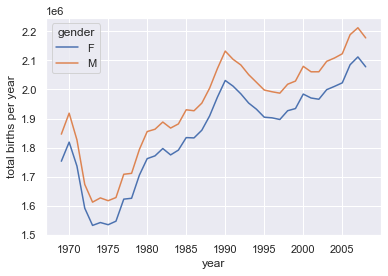

In [2]:
f = df.loc[df.gender == "F"].groupby("year").births.sum()
m = df.loc[df.gender == "M"].groupby("year").births.sum()

fig, ax = plt.subplots()
ax.plot(f, label='F')
ax.plot(m, label='M')
ax.set_xlabel('year')
ax.set_ylabel('total births per year')
ax.legend(title='gender')
plt.show()

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

In [3]:
# the first graph is the relative number of births per day compare to the annual daily average (summer is busy)
# periodic component indicates the cyclical patterns, for example there's less births on weekends 
# residual is the difference between the predicted value (smooted average) and the recorded values
# it points out outliers with less births like new year eve, christmas, independance day, labor day, thanksgiving and february 29th  
# and valentine's day with more births

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

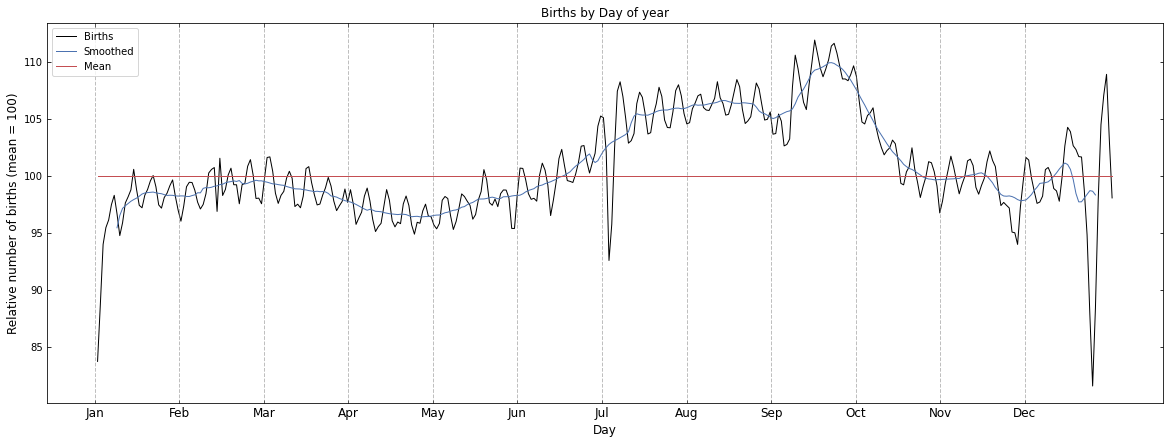

In [4]:
import datetime as dt
import numpy as np
sns.reset_orig()
df = pd.read_csv("data/births.csv")

# clean
df = df.dropna()
df = df.drop(df.index[df.day == 99.0])
df.day = df.day.astype(int)
df['date'] = pd.to_datetime(df[['year', 'month', 'day']] , errors='coerce')

# normalized births
df['norm'] = df.births / df.births.mean() * 100
df['avg'] = 100

# create series
df['day_of_year'] = df.date.dt.dayofyear
dt = df.groupby("day_of_year").norm.mean()
avg = df.groupby("day_of_year").avg.mean() 
rol = dt.rolling(14, center=True).mean()

# graph
fig, ax = plt.subplots(figsize=(20, 7))

ax.plot(dt, '-', linewidth=1, color='black', label='Births')
ax.plot(rol, '-', linewidth=1, color='b', label='Smoothed')
ax.plot(avg, '-', linewidth=1, color='r', label='Mean')

ax.legend()
ax.set_title('Births by Day of year')
ax.set_xlabel('Day', size=12)
ax.set_ylabel('Relative number of births (mean = 100)', size=12)
ax.tick_params(direction = 'in', top = True, right = True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), size=12)
for tick in plt.xticks()[0]:
    plt.axvline(tick, color='gray', linestyle='--', linewidth=1, alpha=.5)

plt.show()


# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [5]:
import gzip

with gzip.open('data/recipe.json.gz', 'r') as f:
    data = (line.strip().decode() for line in f)
    data_json = f"[{','.join(data)}]"
recipes = pd.read_json(data_json)

In [6]:
recipes.description.str.lower().str.contains("breakfast").sum() # 3524

3524

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [7]:
def recommend_ingredients(ing_list, df):

    all_list = ['salt', 'pepper', 'oregano', 'sage', 'parsley',
                'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
    
    # shoulf be done outside the function if reused
    for ing in all_list: 
        df[ing] = df.ingredients.str.lower().str.contains(ing)

    for ing in ing_list: 
        df = df.loc[df[ing] == True]

    return df.index

In [8]:
recommend_ingredients(["parsley", "paprika", "tarragon"], recipes)

Int64Index([  2069,  74964,  93768, 113926, 137686, 140530, 158475, 158486,
            162896, 163175, 165243, 171774],
           dtype='int64')

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [9]:
"""
movies_url = {
"movies_metadata": "1RLvh6rhzYiDDjPaudDgyS9LmqjbKH-wh",
"keywords": "1YLOIxb-EPC_7QpkmRqkq9E6j7iqmoEh3",
"ratings": "1_5HNurSOMnU0JIcXBJ5mv1NaXCx9oCVG",
"credits": "1bX9othXfLu5NZbVZtIPGV5Hbn8b5URPf",
"ratings_small": "1fCWT69efrj4Oxdm8ZNoTeSahCOy6_u6w",
"links_small": "1fh6pS7XuNgnZk2J3EmYk_9jO_Au_6C15",
"links": "1hWUSMo_GwkfmhehKqs8Rs6mWIauklkbP",
}

def read_gdrive(url):
    # Reads file from Google Drive sharing link
    path = 'https://drive.google.com/uc?export=download&id='+url
    return pd.read_csv(path)

metadata = read_gdrive(movies_url["movies_metadata"])
credits = read_gdrive(movies_url["credits"])
"""

metadata = pd.read_csv("data/imdb/movies_metadata.csv")
credits = pd.read_csv("data//imdb/credits.csv")
#ratings_small = pd.read_csv("data//imdb/ratings_small.csv")
#ratings = pd.read_csv("data//imdb/ratings.csv")

In [10]:
import json

credits['directors'] = (credits.crew
    .apply(eval)
    #.str.replace("'", '"')
    #.apply(json.loads)
    .apply(lambda row : [d['name'] for d in row])
    .apply(lambda row : row[:1])
    .astype(str)
    .str.replace("[", "")
    .str.replace("]", "")
)

In [26]:
cred = credits[['id','directors']]
cred.id = cred.id.astype(str)
meta = metadata[['id','title', 'revenue', 'vote_count', 'vote_average']]
meta.id = meta.id.astype(str)
merge = pd.merge(meta, cred, on='id')
# movies should have more than 100 votes and generated more than $1M
merge = merge.loc[(merge.vote_count > 100) & (merge.revenue > 1000000)]
group = merge.groupby('directors')
agg_dict = {
    "title": 'count',
    "revenue": np.sum,
    "vote_count": np.sum,
    "vote_average": 'mean',
}
result = group.agg(agg_dict).reset_index()
# directors should have made 5 movies or more 
result = result.loc[result.title >= 5]
result = result.sort_values(by='vote_average',ascending=False)

In [27]:
result.head(10)

,directors,title,revenue,vote_count,vote_average
183,'Billy Wilder',6,5.880000e+07,2065.0,7.800000
1696,'Stanley Kubrick',8,2.843543e+08,15866.0,7.775000
686,'Hayao Miyazaki',8,9.747574e+08,10237.0,7.612500
1370,'Park Chan-wook',5,4.707596e+07,3243.0,7.580000
60,'Alfred Hitchcock',11,1.263143e+08,5348.0,7.463636
1197,'Martin Scorsese',8,3.101344e+08,9188.0,7.462500
87,'Andrew Stanton',9,6.060775e+09,41795.0,7.255556
1468,'Quentin Tarantino',9,1.090584e+09,32469.0,7.233333
1585,'Roman Polanski',6,2.613707e+08,4873.0,7.233333
1081,'Lars von Trier',6,9.215517e+07,3203.0,7.216667
